In [1]:
import data_smoothing
import find_peaks
import peak_character
import peak_classify
import feature_visualizer

In [90]:
data_nm, data_time, data_z = data_smoothing.load_data_csv('exp03_20180103 -t0 -chirp.csv', 900, 1400, 1)

In [92]:
smooth_matx = data_smoothing.earth_smooth_matrix(data_nm, data_z)

/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:802: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  pruning_passer.run()
/Users/demiliu/miniconda3/lib/python3.6/site-packages/sklearn_contrib_py_earth-0.1.0-py3.6-macosx-10.7-x86_64.egg/pyearth/earth.py:1055: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coef, resid = np.linalg.lstsq(B, weighted_y[:, i])[0:2]


In [93]:
threshold = 0
mindist = 0
idx, height, fwhm = peak_character.peak_matrix(data_nm,smooth_matx, threshold, mindist)

In [99]:
height.describe()

,0,1,2
count,666.000000,186.000000,7.000000
mean,-0.001437,-0.000950,-0.000214
std,0.000475,0.000559,0.000165
min,-0.003789,-0.001443,-0.000393
25%,-0.001411,-0.001320,-0.000330
50%,-0.001318,-0.001255,-0.000258
75%,-0.001217,-0.000160,-0.000102
max,-0.000230,0.000071,0.000017


In [101]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

def data_grouping(index_df, height_df, fwhm_df):
    peak_list = []
    
    for i in range(index_df.shape[0]):
        for j in range(index_df.shape[1]):
            peak_list.append(
            [index_df.loc[i,j], height_df.loc[i,j], fwhm_df.loc[i,j], i])
        
    all_points = pd.DataFrame(peak_list, 
    columns=['Position', 'Height', 'Width', 'Time'])
    fill_na = all_points.fillna(value=0)
    corrected_output = fill_na.drop(fill_na[abs(fill_na.Height) < 0.0002].index)
    corrected_output = corrected_output.reset_index(drop=True)
    
    return corrected_output

def cluster_classifier(index_df, corrected_output):
    found_peak = index_df.shape[1]
    cluster = KMeans(n_clusters=found_peak).fit(corrected_output.iloc[:,:-2])
    print(cluster.labels_)
    print(cluster.cluster_centers_)
    cluster_dict = {}
    
    for i in range(found_peak):
            cluster_dict['peak_%s' % i] = []
            
    for j in range(corrected_output.shape[0]):
        peak = cluster.predict([corrected_output.values[j,:-2]])
        for k in range(found_peak):
            if (peak == k):
                cluster_dict['peak_%s' % k].append(corrected_output.values[j])
                #print('found a match')

    peak_dict = { k:v for k, v in cluster_dict.items() if len(v) >= 5}
    return peak_dict

In [102]:
corrected_output = data_grouping(idx, height, fwhm)
corrected_output.describe()

,Position,Height,Width,Time
count,807.00000,807.000000,807.000000,807.00000
mean,48.10285,-0.001404,174.902382,291.45601
std,15.97301,0.000446,39.606767,199.12853
min,6.00000,-0.003789,83.450000,0.00000
25%,51.00000,-0.001396,161.760000,109.00000
50%,55.00000,-0.001311,165.260000,267.00000
75%,56.00000,-0.001220,182.363000,466.50000
max,125.00000,-0.000210,350.989000,665.00000


In [103]:
peak_dict = peak_classify.cluster_classifier(idx, corrected_output)

In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit

def visualize(peak_dict, data_nm):
    fs = 20
    nm = pd.DataFrame(data_nm)
    i = 0
    nm_list = []
    df = pd.DataFrame(peak_dict['peak_%s' % i], 
    columns=['Position', 'Height', 'Width', 'Time'])
    df = df.drop_duplicates(subset= 'Time')
    df = df.reset_index(drop=True)
    for j in df['Position']:
        nm_list.append(nm.loc[j].values)
    
    df['Wavelength'] = nm_list
        
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=100)

    ax1.plot(df['Time'], df['Height'], '.', color = 'purple')
    
    ax1.set_title('Peak %s Dynamics' % (i+1), fontsize=18, fontweight='bold')
    ax1.set_ylabel('Intensity', fontsize=fs, fontweight='bold')
    ax1_yticks = [-0.0018, -0.0014, -0.0008, -0.0004, 0, 0.0004]
    #ax1.set_yticklabels(ax1_yticks, fontsize = fs-2)
    ax1_xticks = [0, 100, 200, 300, 400, 500]
    
    ax1.set_xticklabels(ax1_xticks, fontsize = fs-2)
    ax1.set_xlim(0, 400)
    
    #ax1.grid()

    ax2.plot(df['Time'], df['Wavelength'], '.', color = 'purple')
    ax2.plot(np.unique(df['Time']), np.poly1d(np.polyfit(df['Time'], df['Position'], 1))(np.unique(df['Time'])))
    ax2.set_xlim(0, 400)
    ax2.set_ylabel('Wavelength (nm)', fontsize=fs, fontweight='bold')
    ax2.set_xlabel('Time (ps)', fontsize=fs, fontweight='bold')
    ax2_yticks = [900, 920, 940, 960, 980, 1000, 1020]
    #ax2.set_xticklabels(ax1_xticks, fontsize = fs-2)
    ax2.set_yticklabels(ax2_yticks, fontsize = fs-2)
    ax2.set_ylim((900, 1400))
    ax1.set_xlim(0, 400)
    #ax2.grid()
        
    return

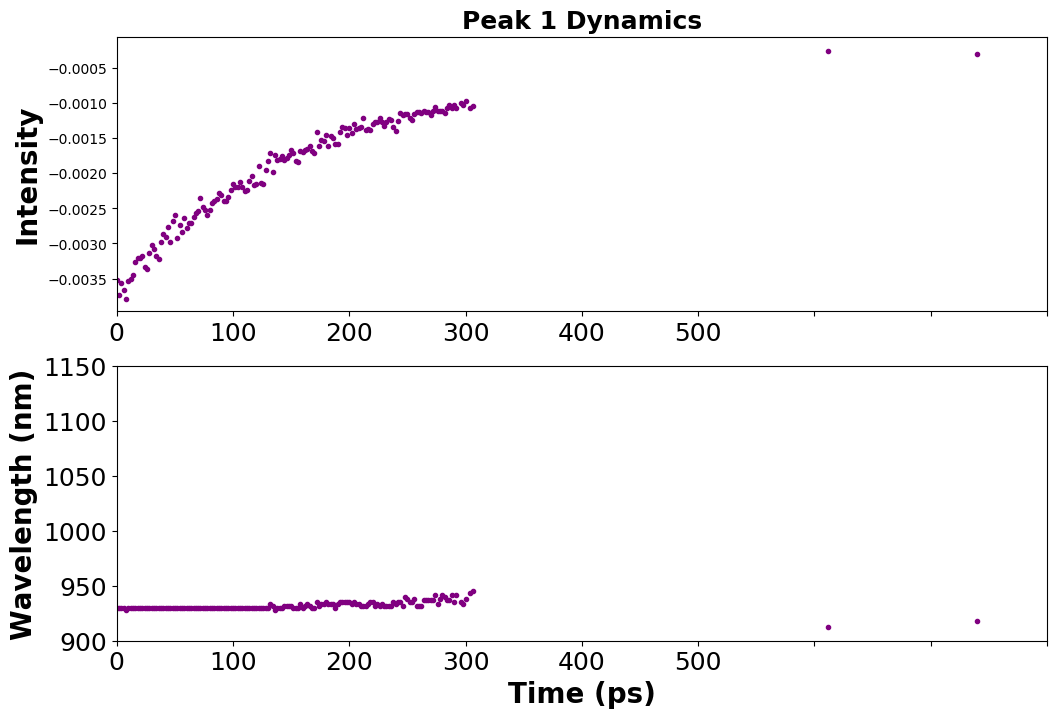

In [119]:
output = visualize(peak_dict, data_nm)

In [68]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.polynomial.polynomial import polyfit

def visualize(peak_dict, data_nm):
    for i in range(len(peak_dict)):
        nm_list = []
        df = pd.DataFrame(peak_dict['peak_%s' % i], 
        columns=['Position', 'Height', 'Width', 'Time'])
        df = df.drop_duplicates(subset= 'Time')
        df = df.reset_index(drop=True)
                
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), dpi=600)
        
        ax1.plot(df['Time'], df['Height'], '.')
        #ax1.plot(exp fit)
        #ax1.axis(between 0 and 1?)
        ax1.set_title('Peak %s Dynamics' % (i+1), fontsize=18, fontweight='bold')
        ax1.set_ylabel('Intensity', fontsize=18, fontweight='bold')
        ax1.grid()
        
        ax2.plot(df['Time'], df['Position'], '.')
        #ax2.plot(np.unique(df['Time']), np.poly1d(np.polyfit(df['Time'], df['Position'], 1))(np.unique(df['Time'])))
        ax2.set_ylabel('Position', fontsize=18, fontweight='bold')
        ax2.set_xlabel('Time $(ps)$', fontsize=18, fontweight='bold')
        ax2.set_ylim((0, 140))
        ax2.grid()
        
    return

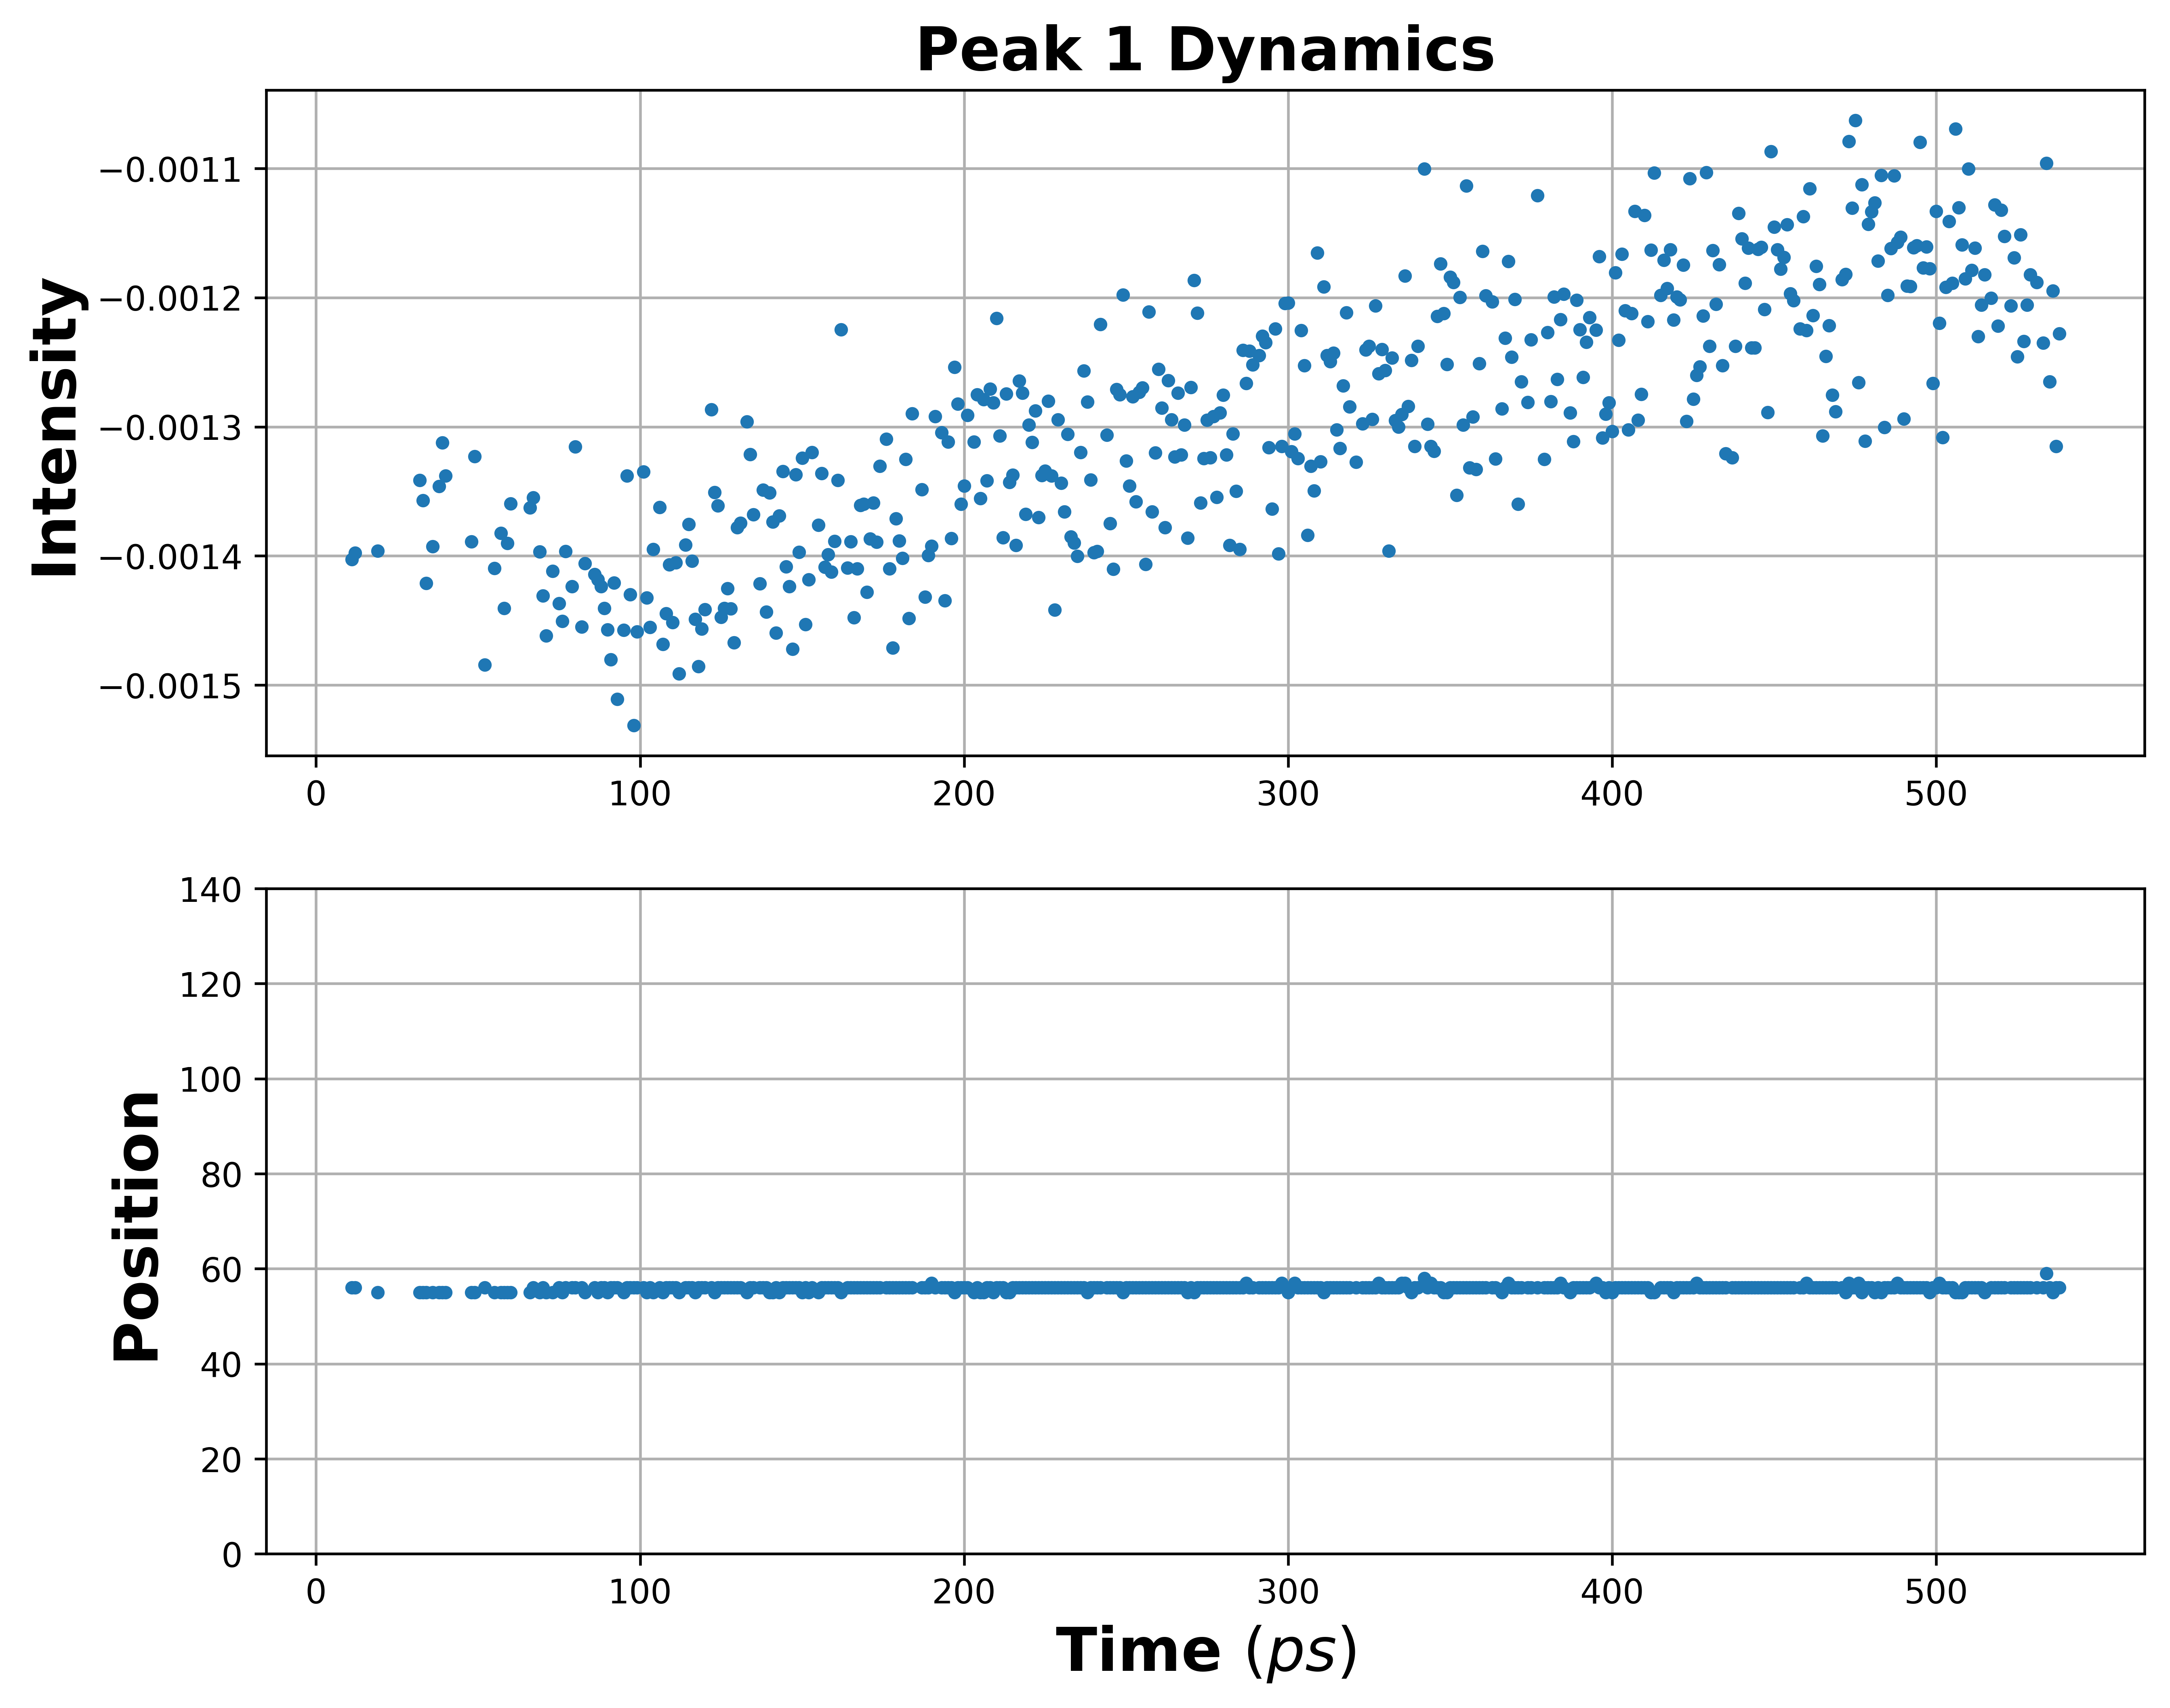

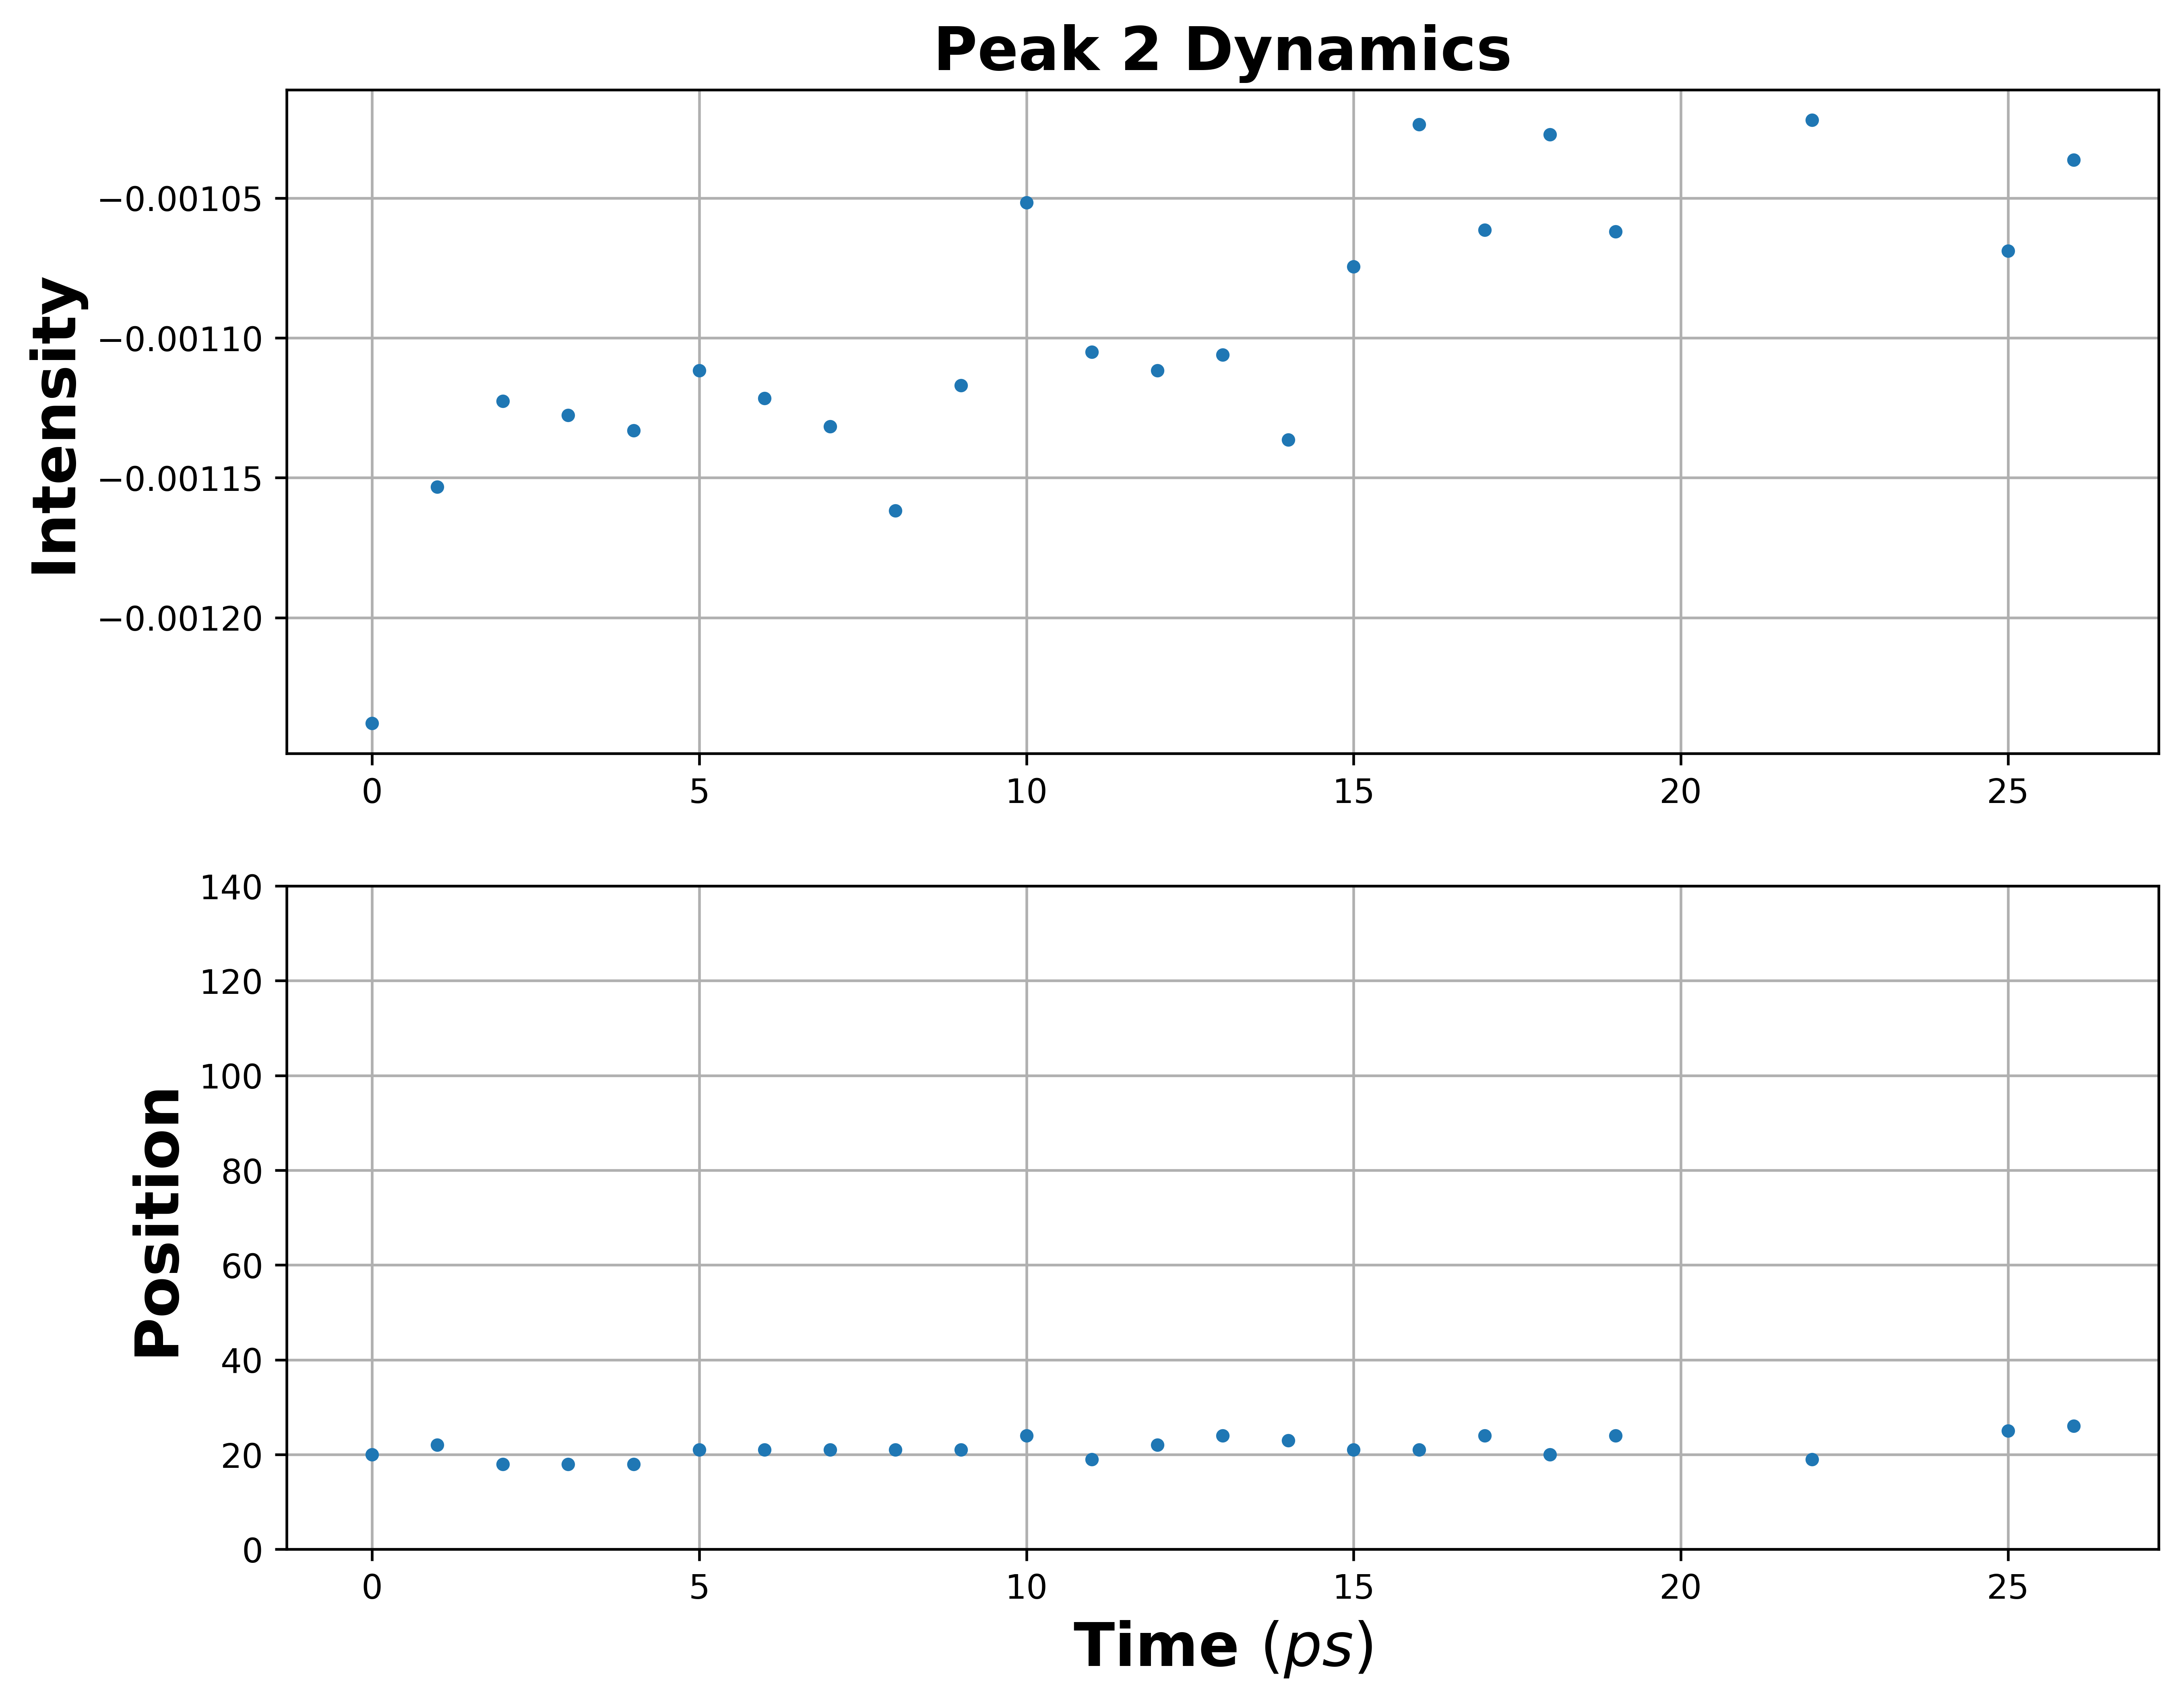

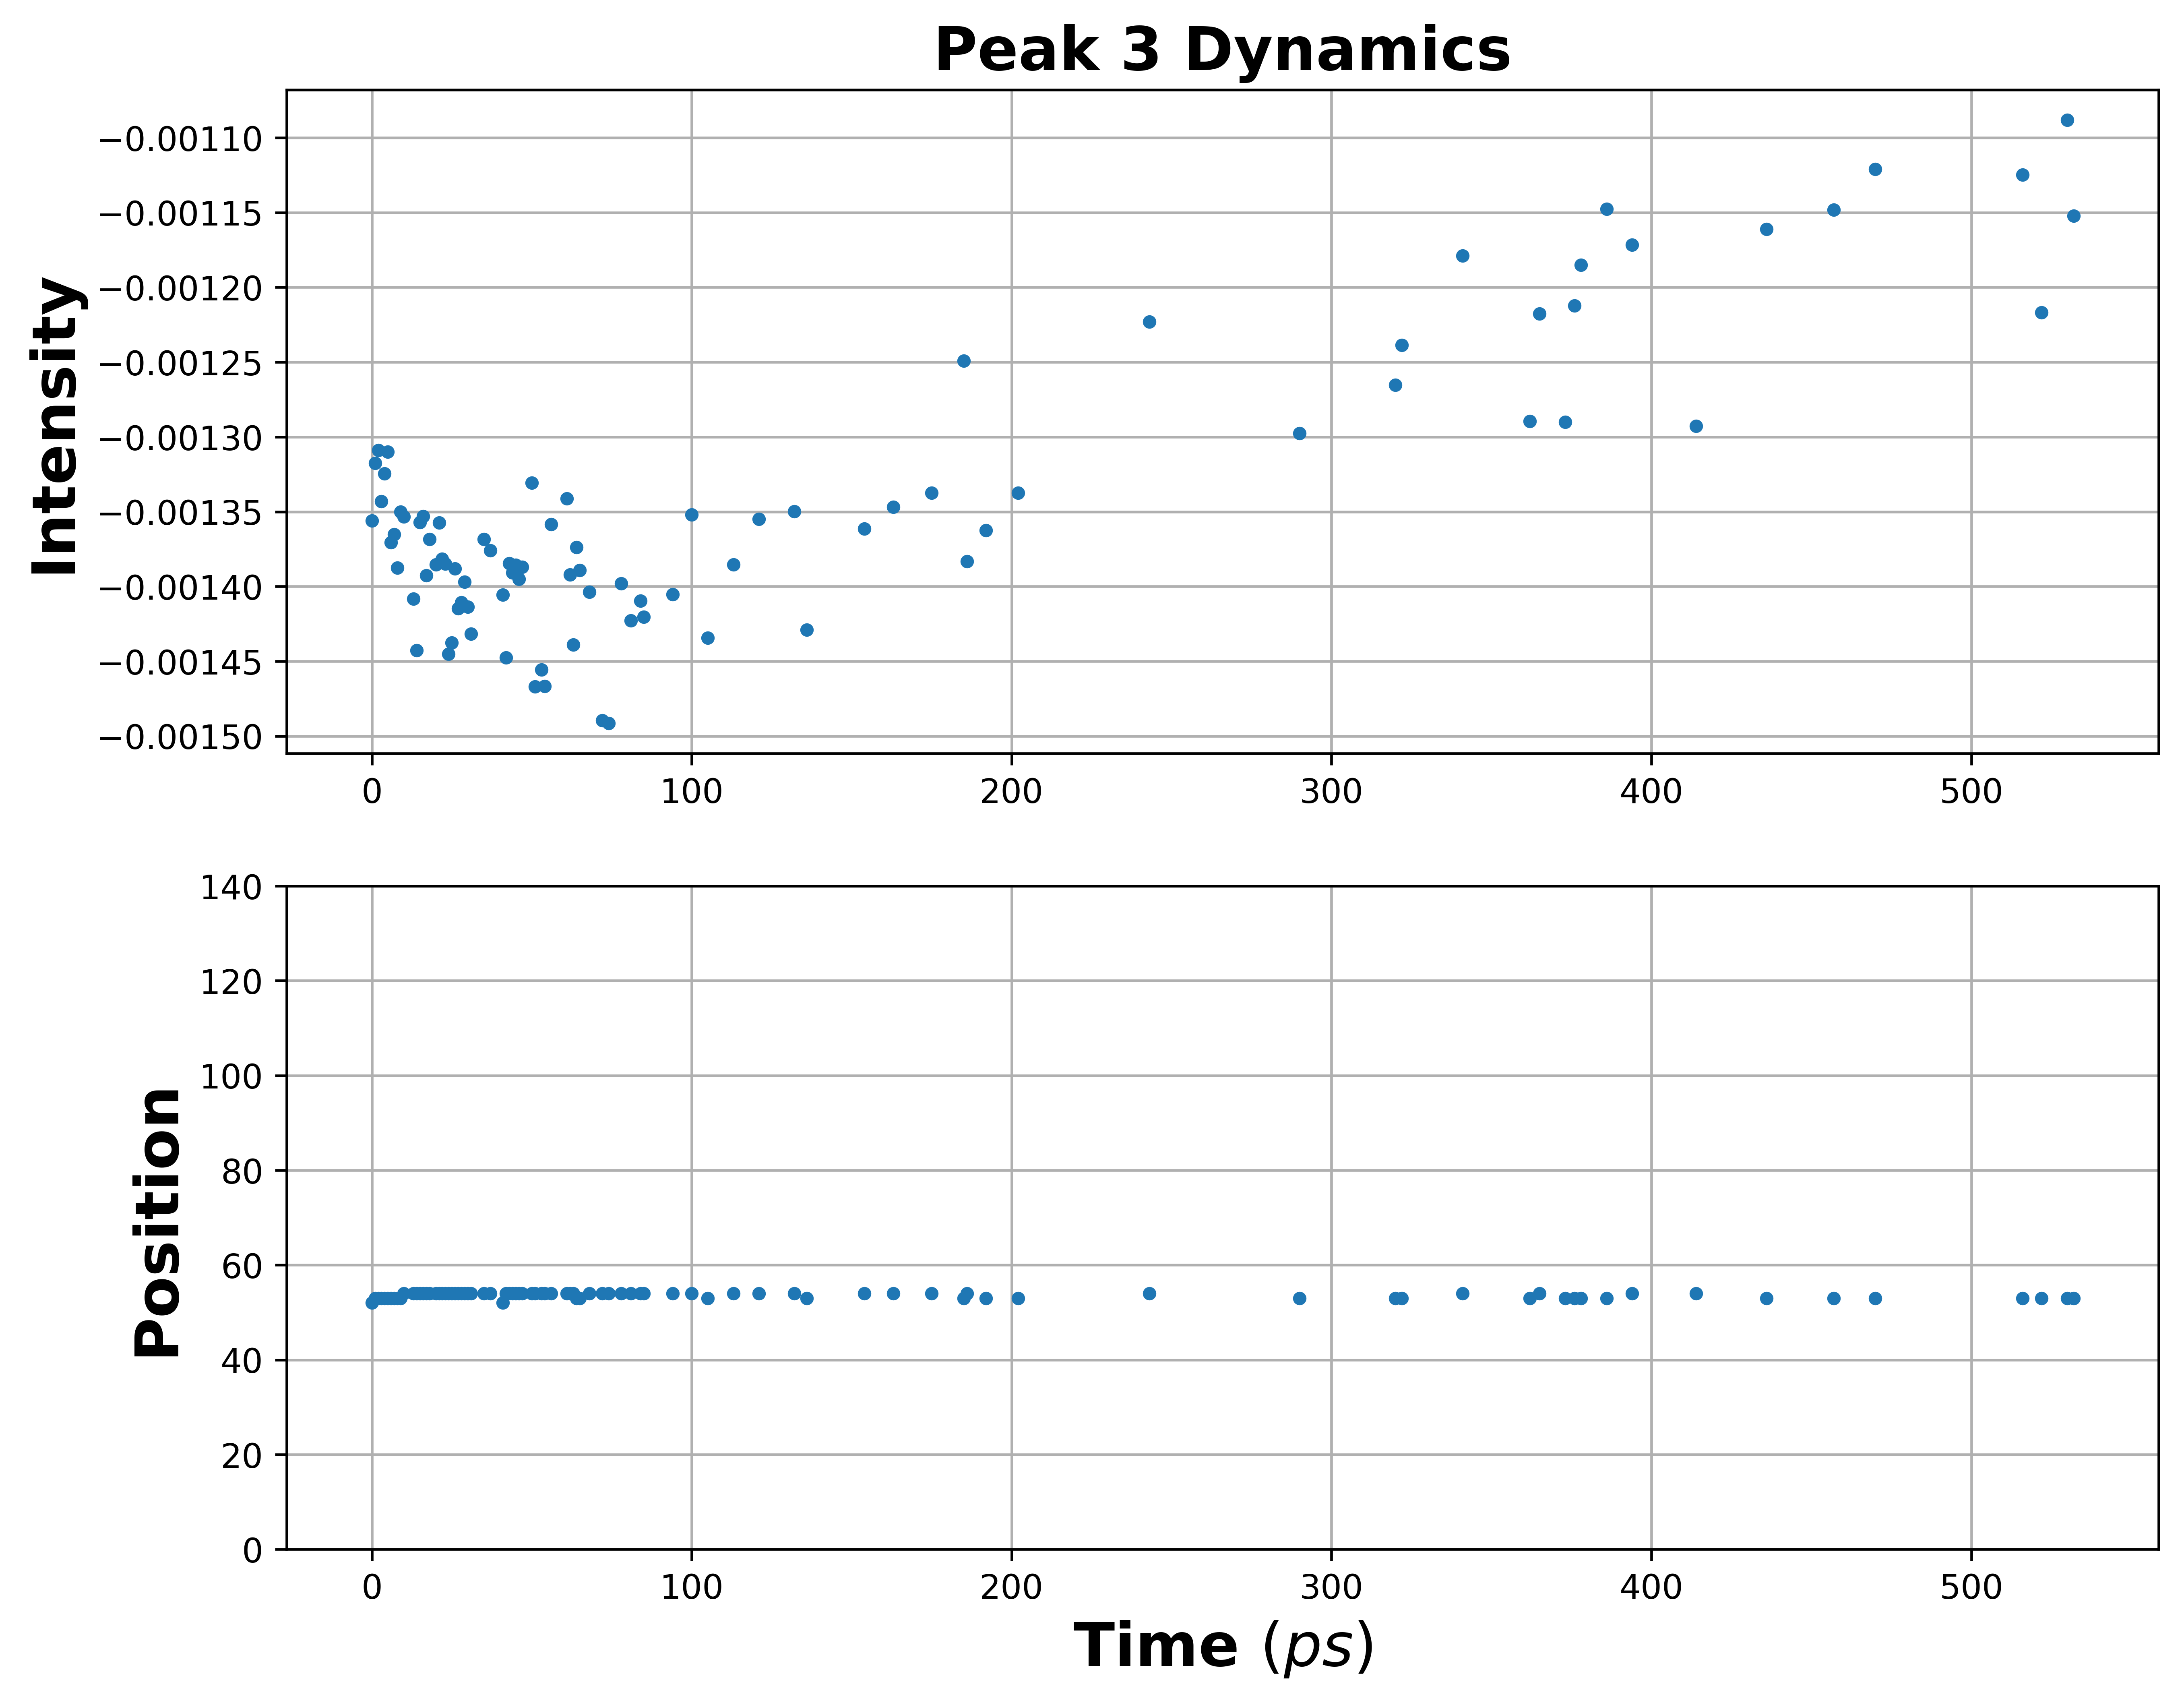

In [69]:
output2 = visualize(peak_dict, data_nm) 

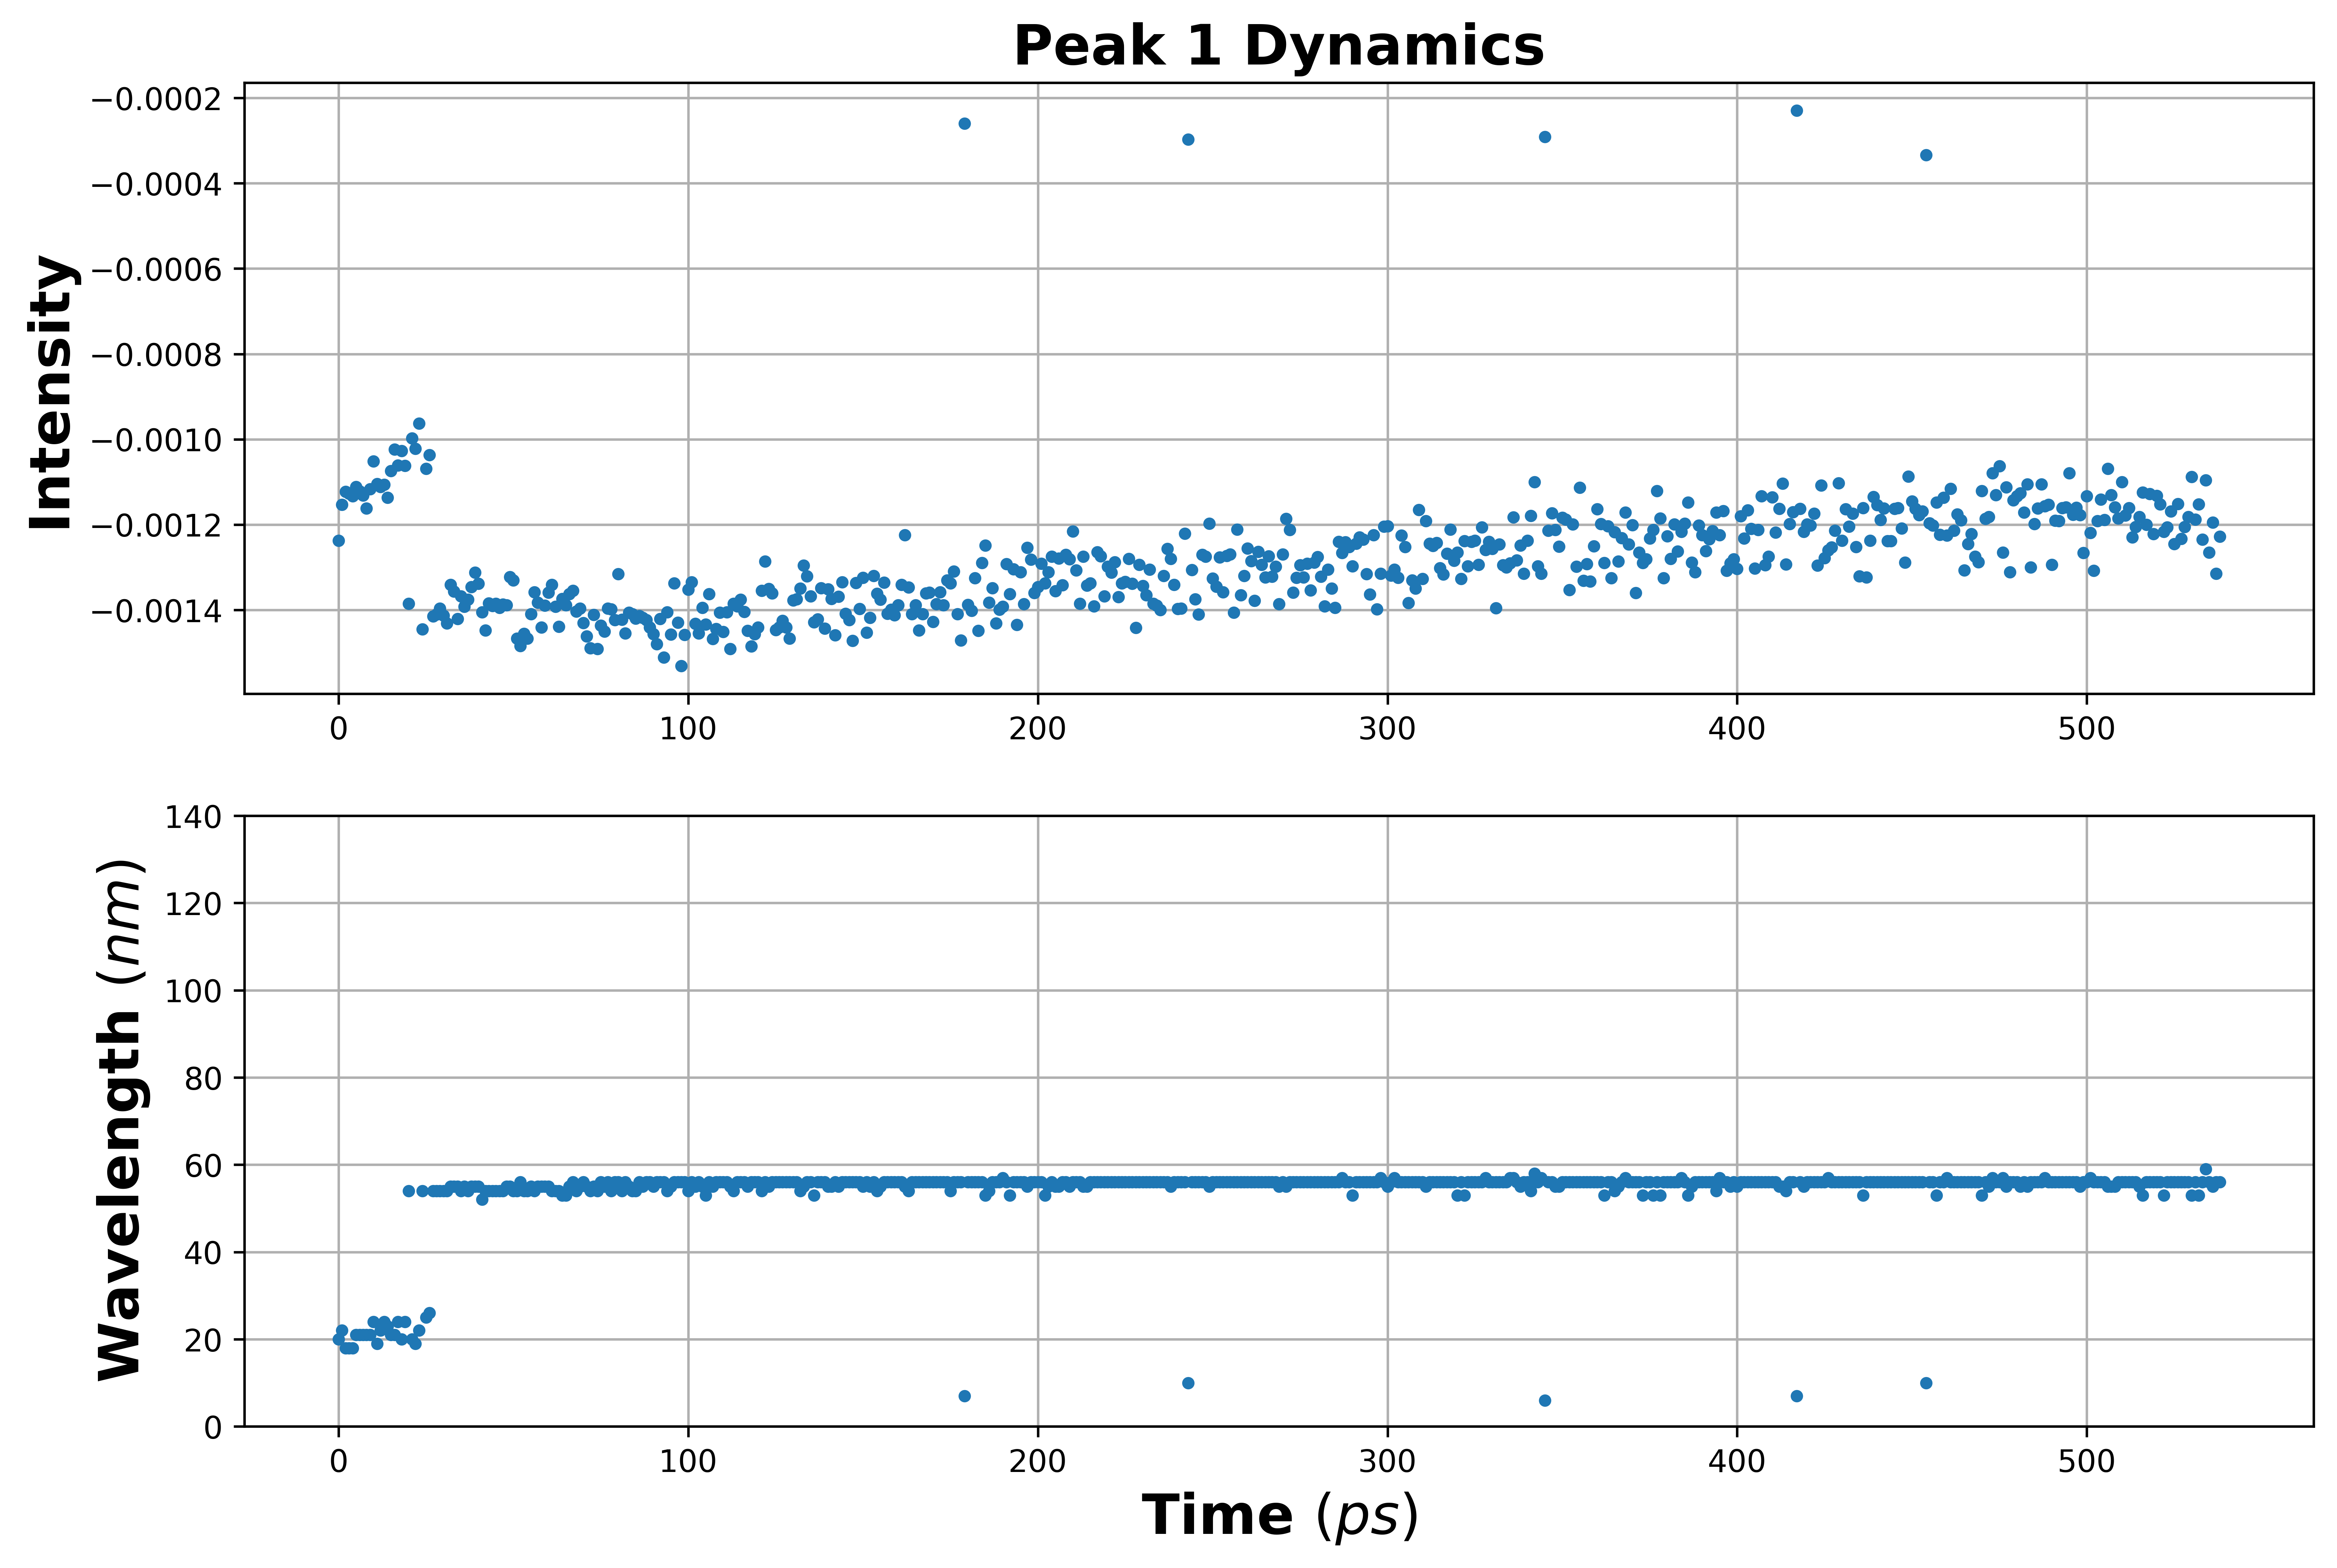

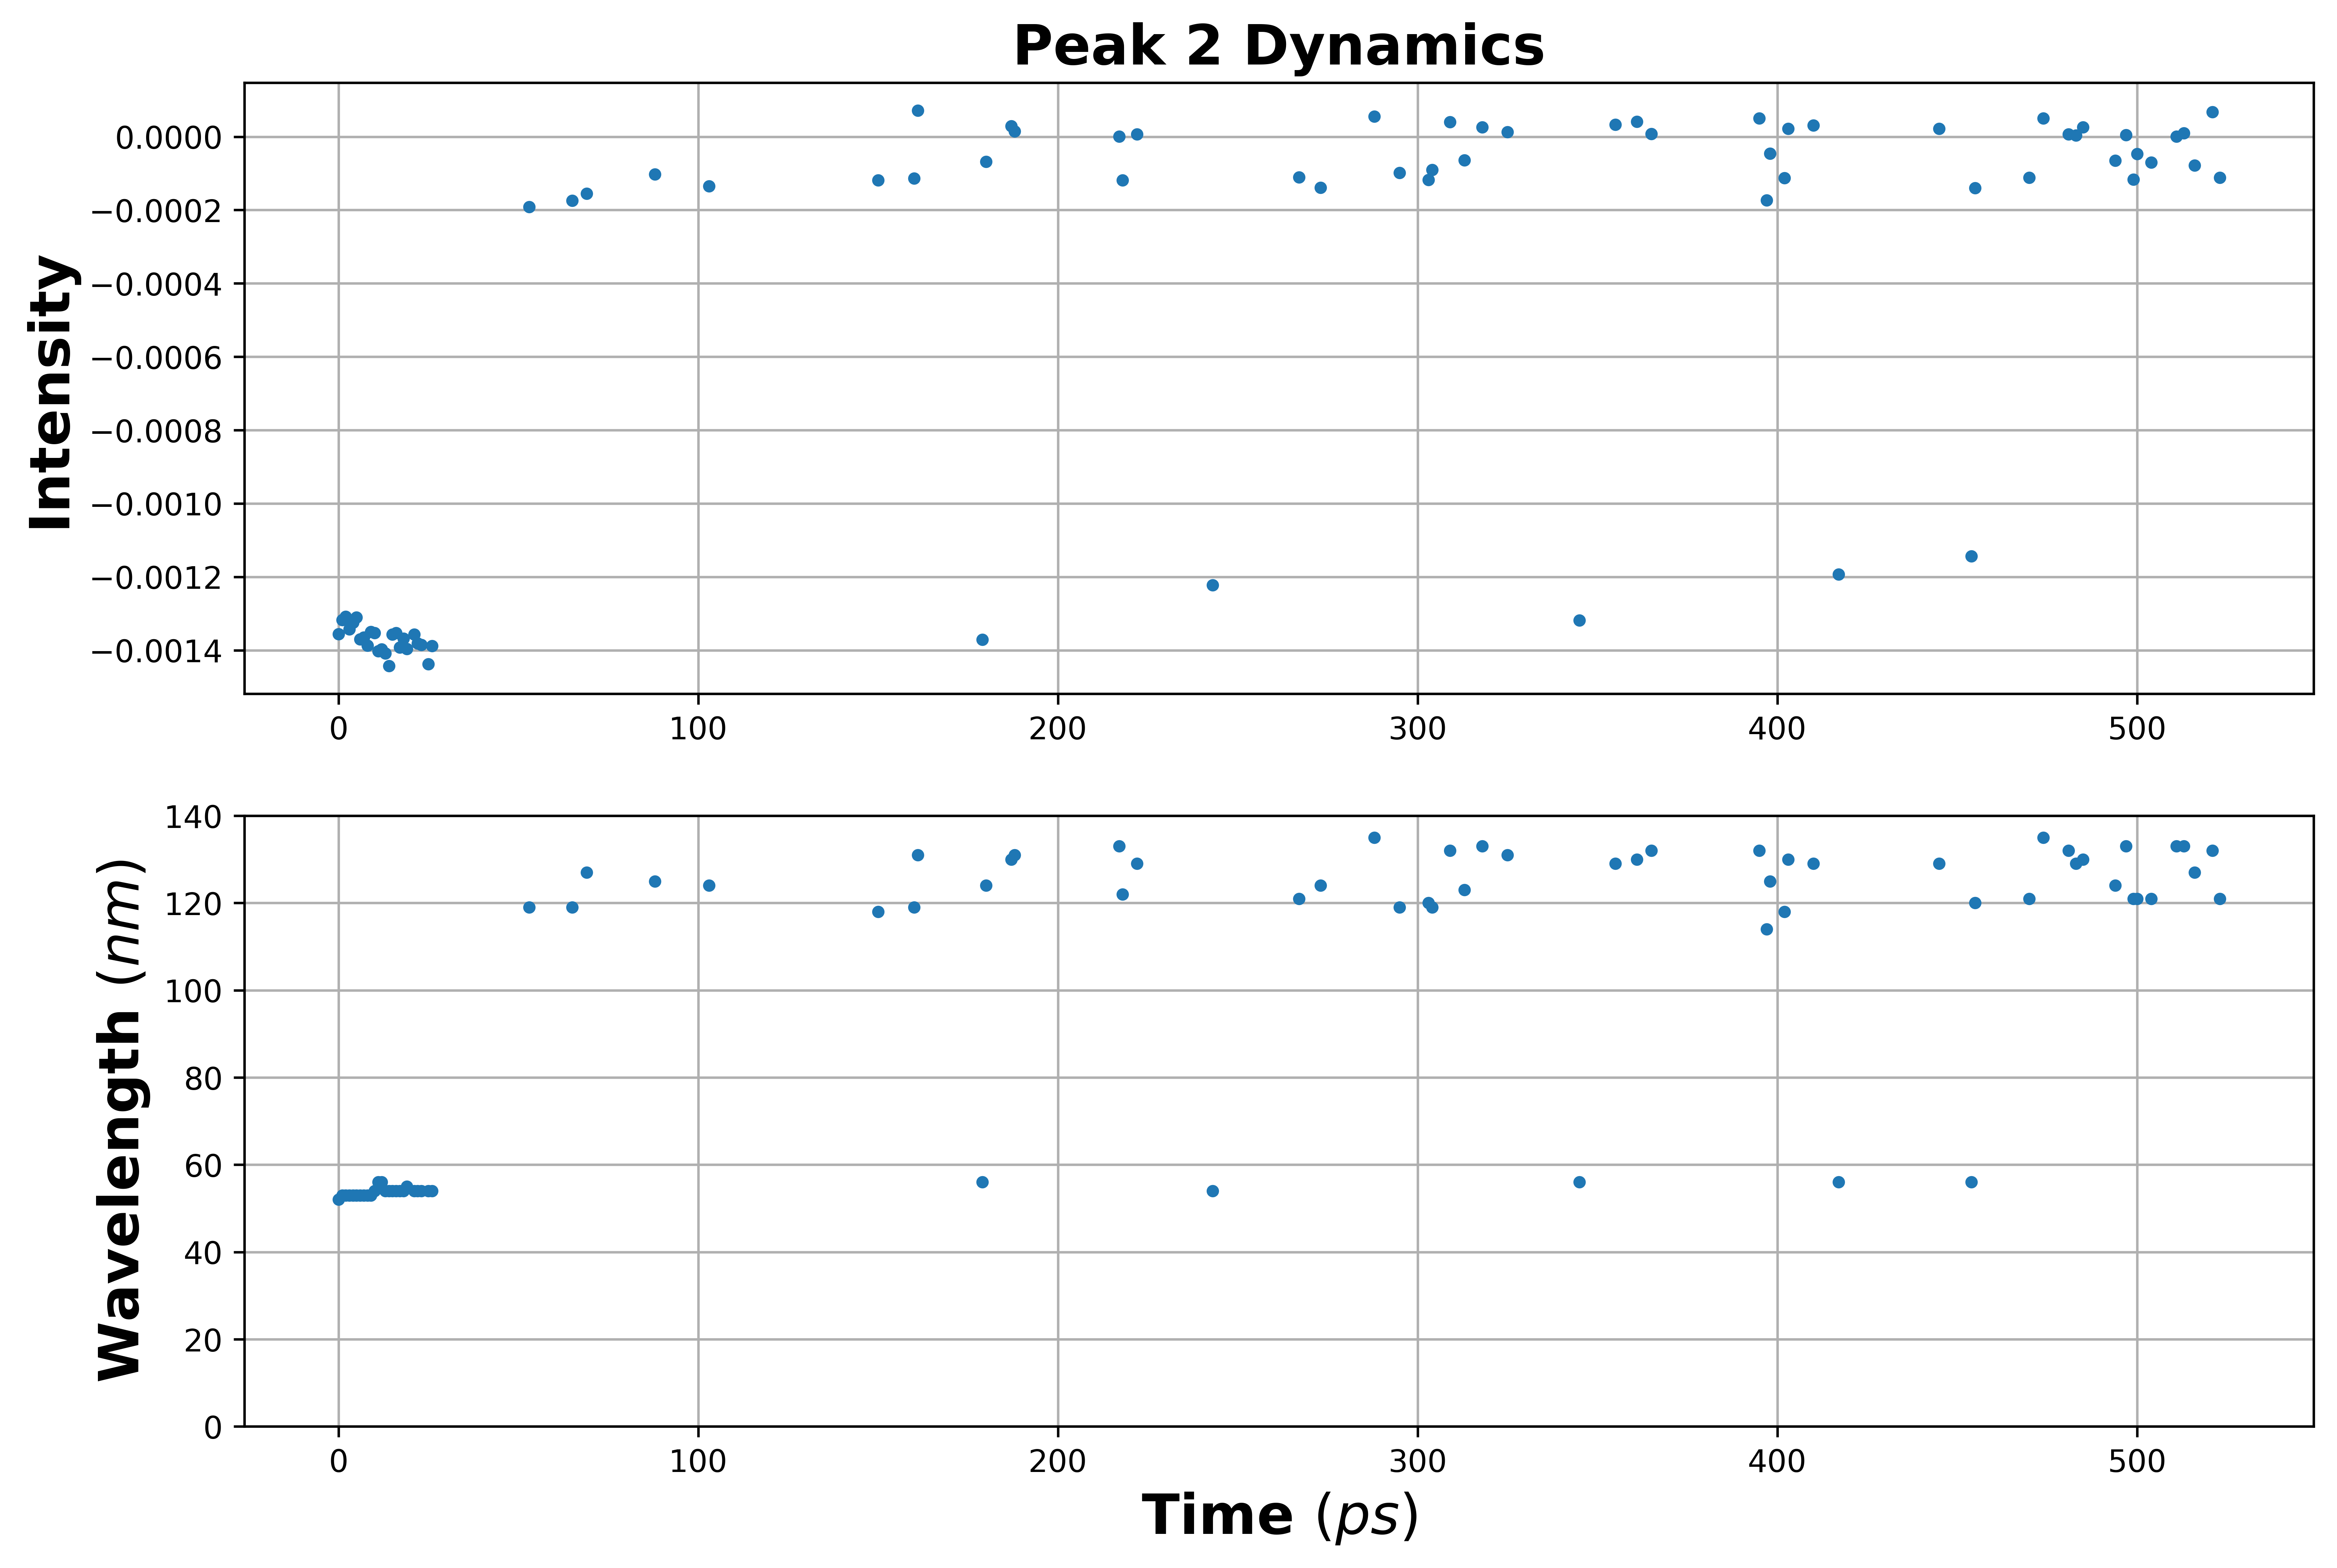

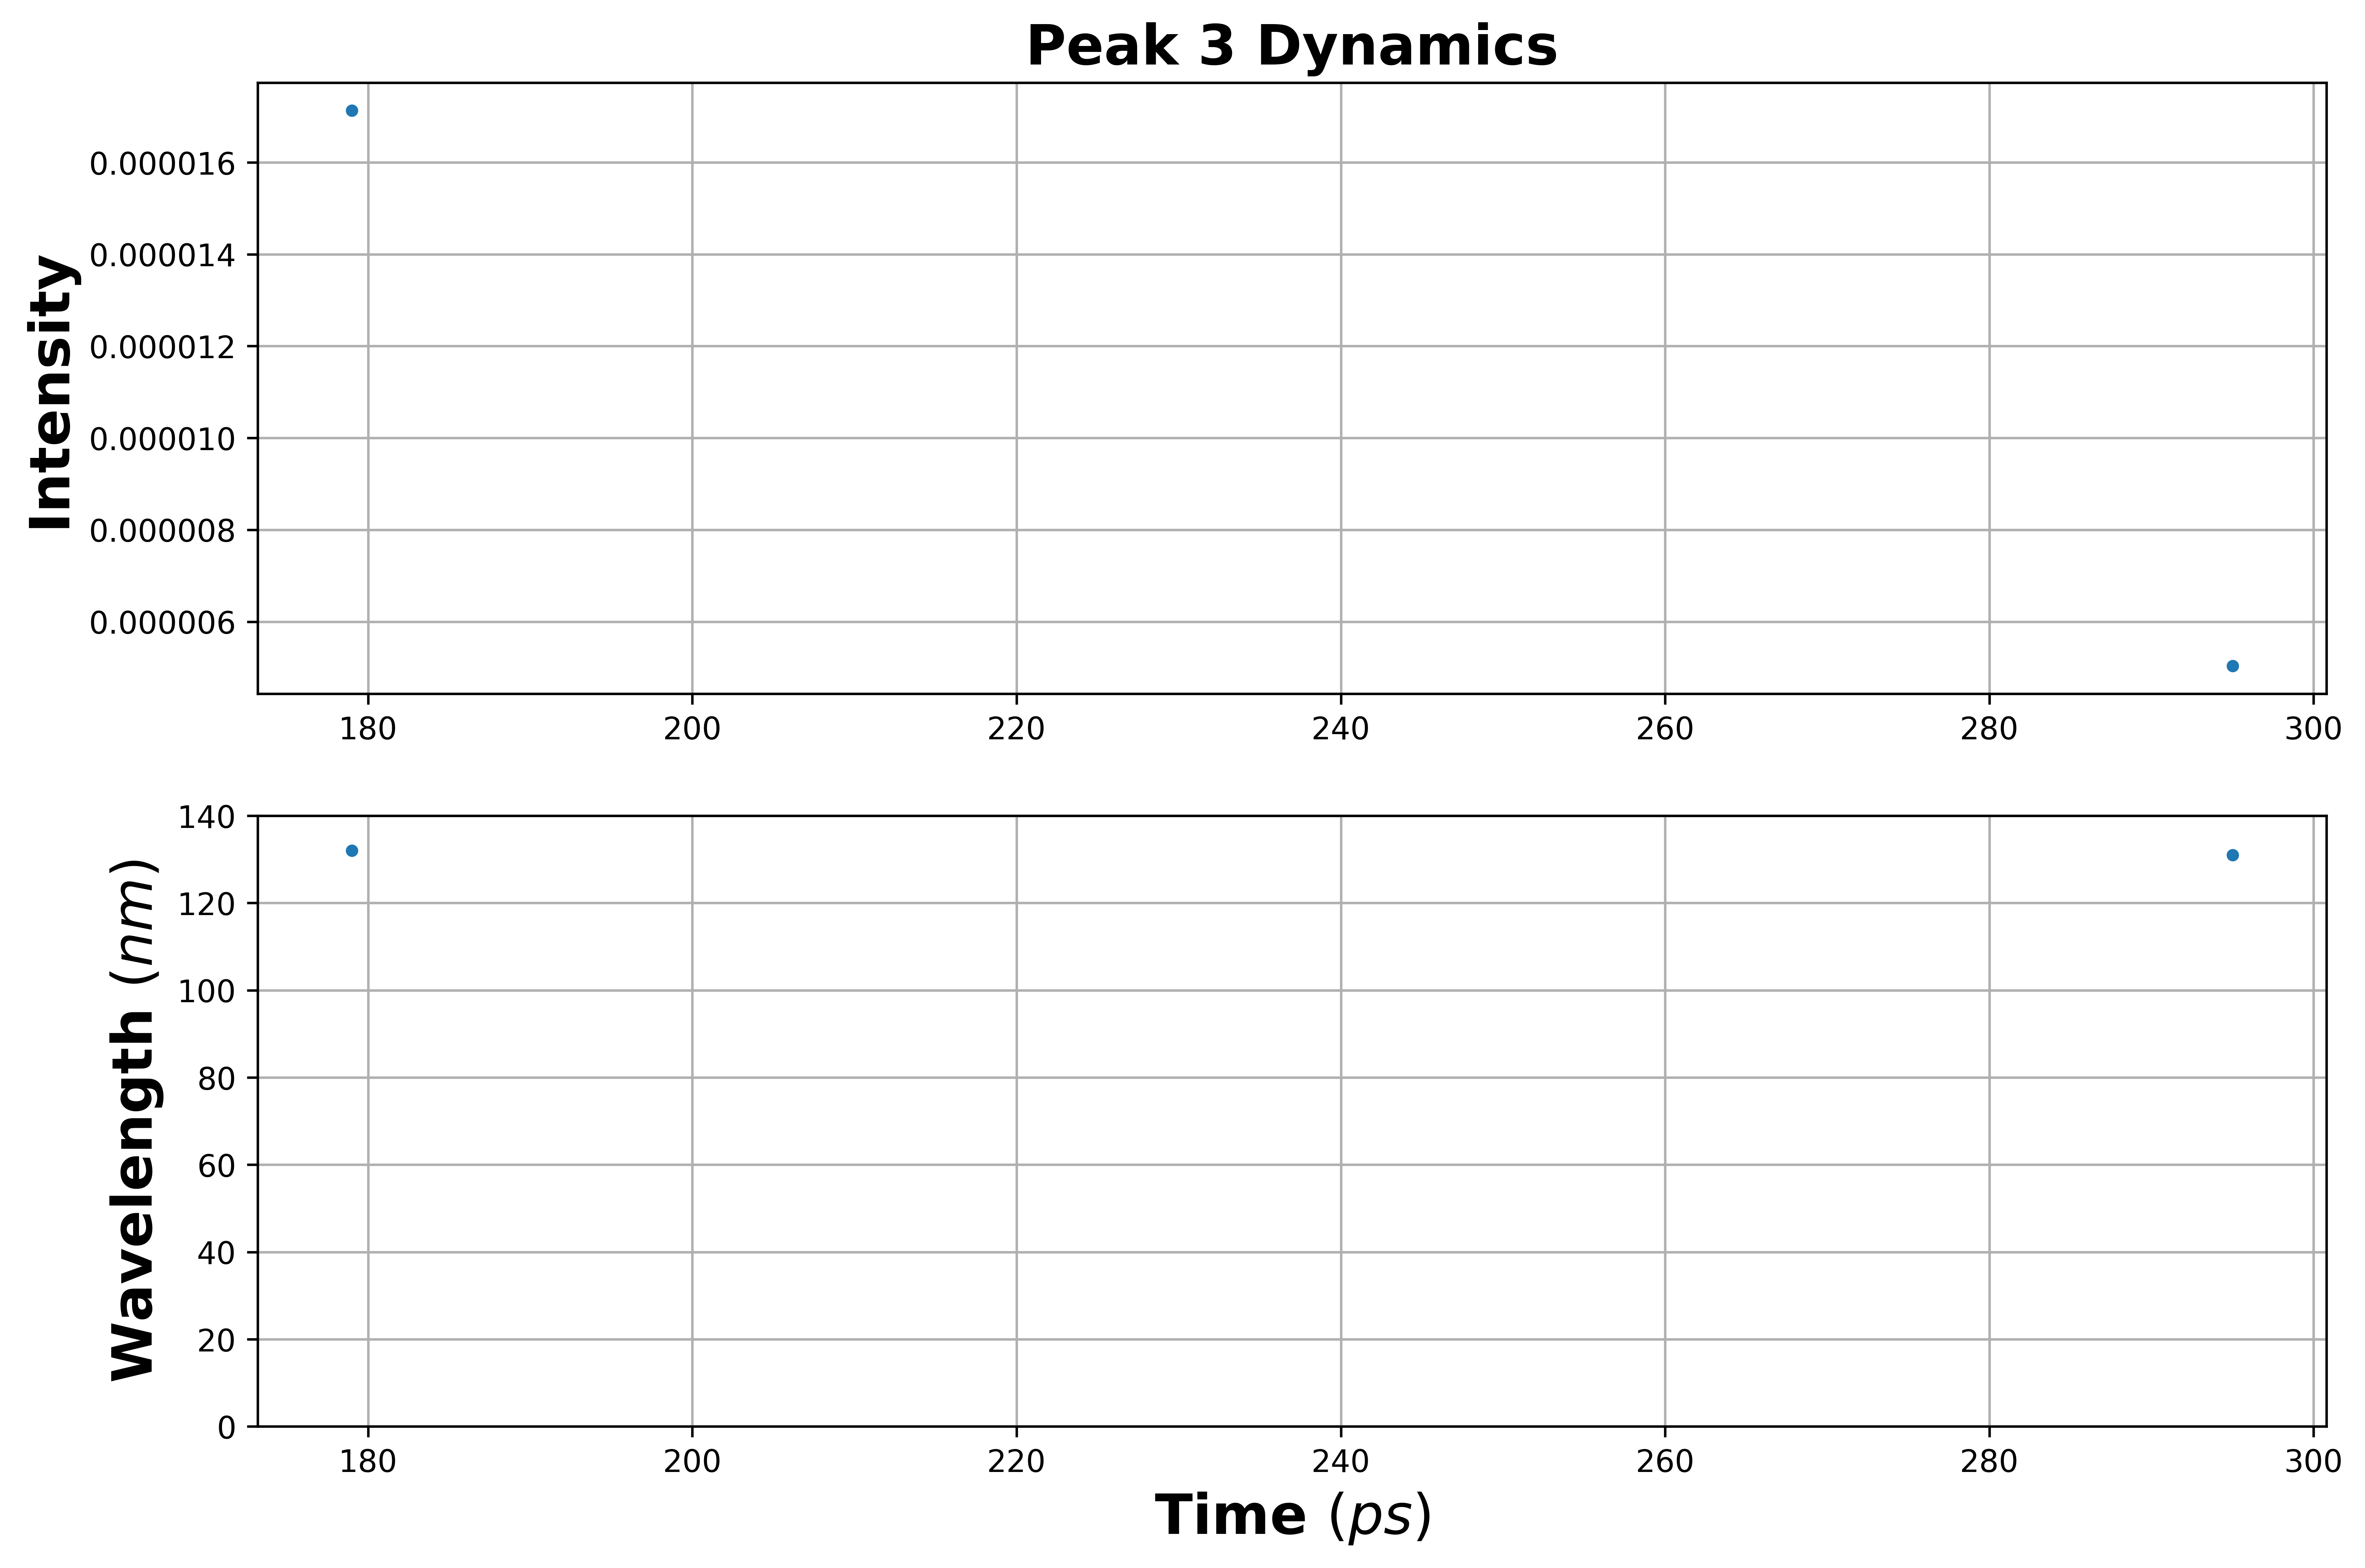

In [70]:
for i in range(idx.shape[1]):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), dpi=600)
        
    ax1.plot(height.loc[:, i], '.')
    #ax1.plot(exp fit)
    #ax1.axis(between 0 and 1?)
    ax1.set_title('Peak %s Dynamics' % (i+1), fontsize=18, fontweight='bold')
    ax1.set_ylabel('Intensity', fontsize=18, fontweight='bold')
    ax1.grid()
        
    ax2.plot(idx.loc[:, i], '.')
    #ax2.plot(np.unique(df['Time']), np.poly1d(np.polyfit(df['Time'], df['Position'], 1))(np.unique(df['Time'])))
    ax2.set_ylabel('Wavelength $(nm)$', fontsize=18, fontweight='bold')
    ax2.set_xlabel('Time $(ps)$', fontsize=18, fontweight='bold')
    ax2.set_ylim((0, 140))
    ax2.grid()

In [120]:
df1 = pd.DataFrame(peak_dict['peak_0'], 
        columns=['Position', 'Height', 'Width', 'Time'])
df1 = df1.drop_duplicates(subset= 'Time')
df1 = df1.reset_index(drop=True)

df2 = pd.DataFrame(peak_dict['peak_1'], 
        columns=['Position', 'Height', 'Width', 'Time'])
df2 = df2.drop_duplicates(subset= 'Time')
df2 = df2.reset_index(drop=True)

nm_1 = pd.DataFrame(data_nm)
i = 0
nm_list_1 = []

for j in df1['Position']:
    nm_list_1.append(nm_1.loc[j].values[0])
    
df1['Wavelength'] = nm_list_1


nm_list_2 = []

for j in df2['Position']:
    nm_list_2.append(nm_1.loc[j].values[0])
    
df2['Wavelength'] = nm_list_2



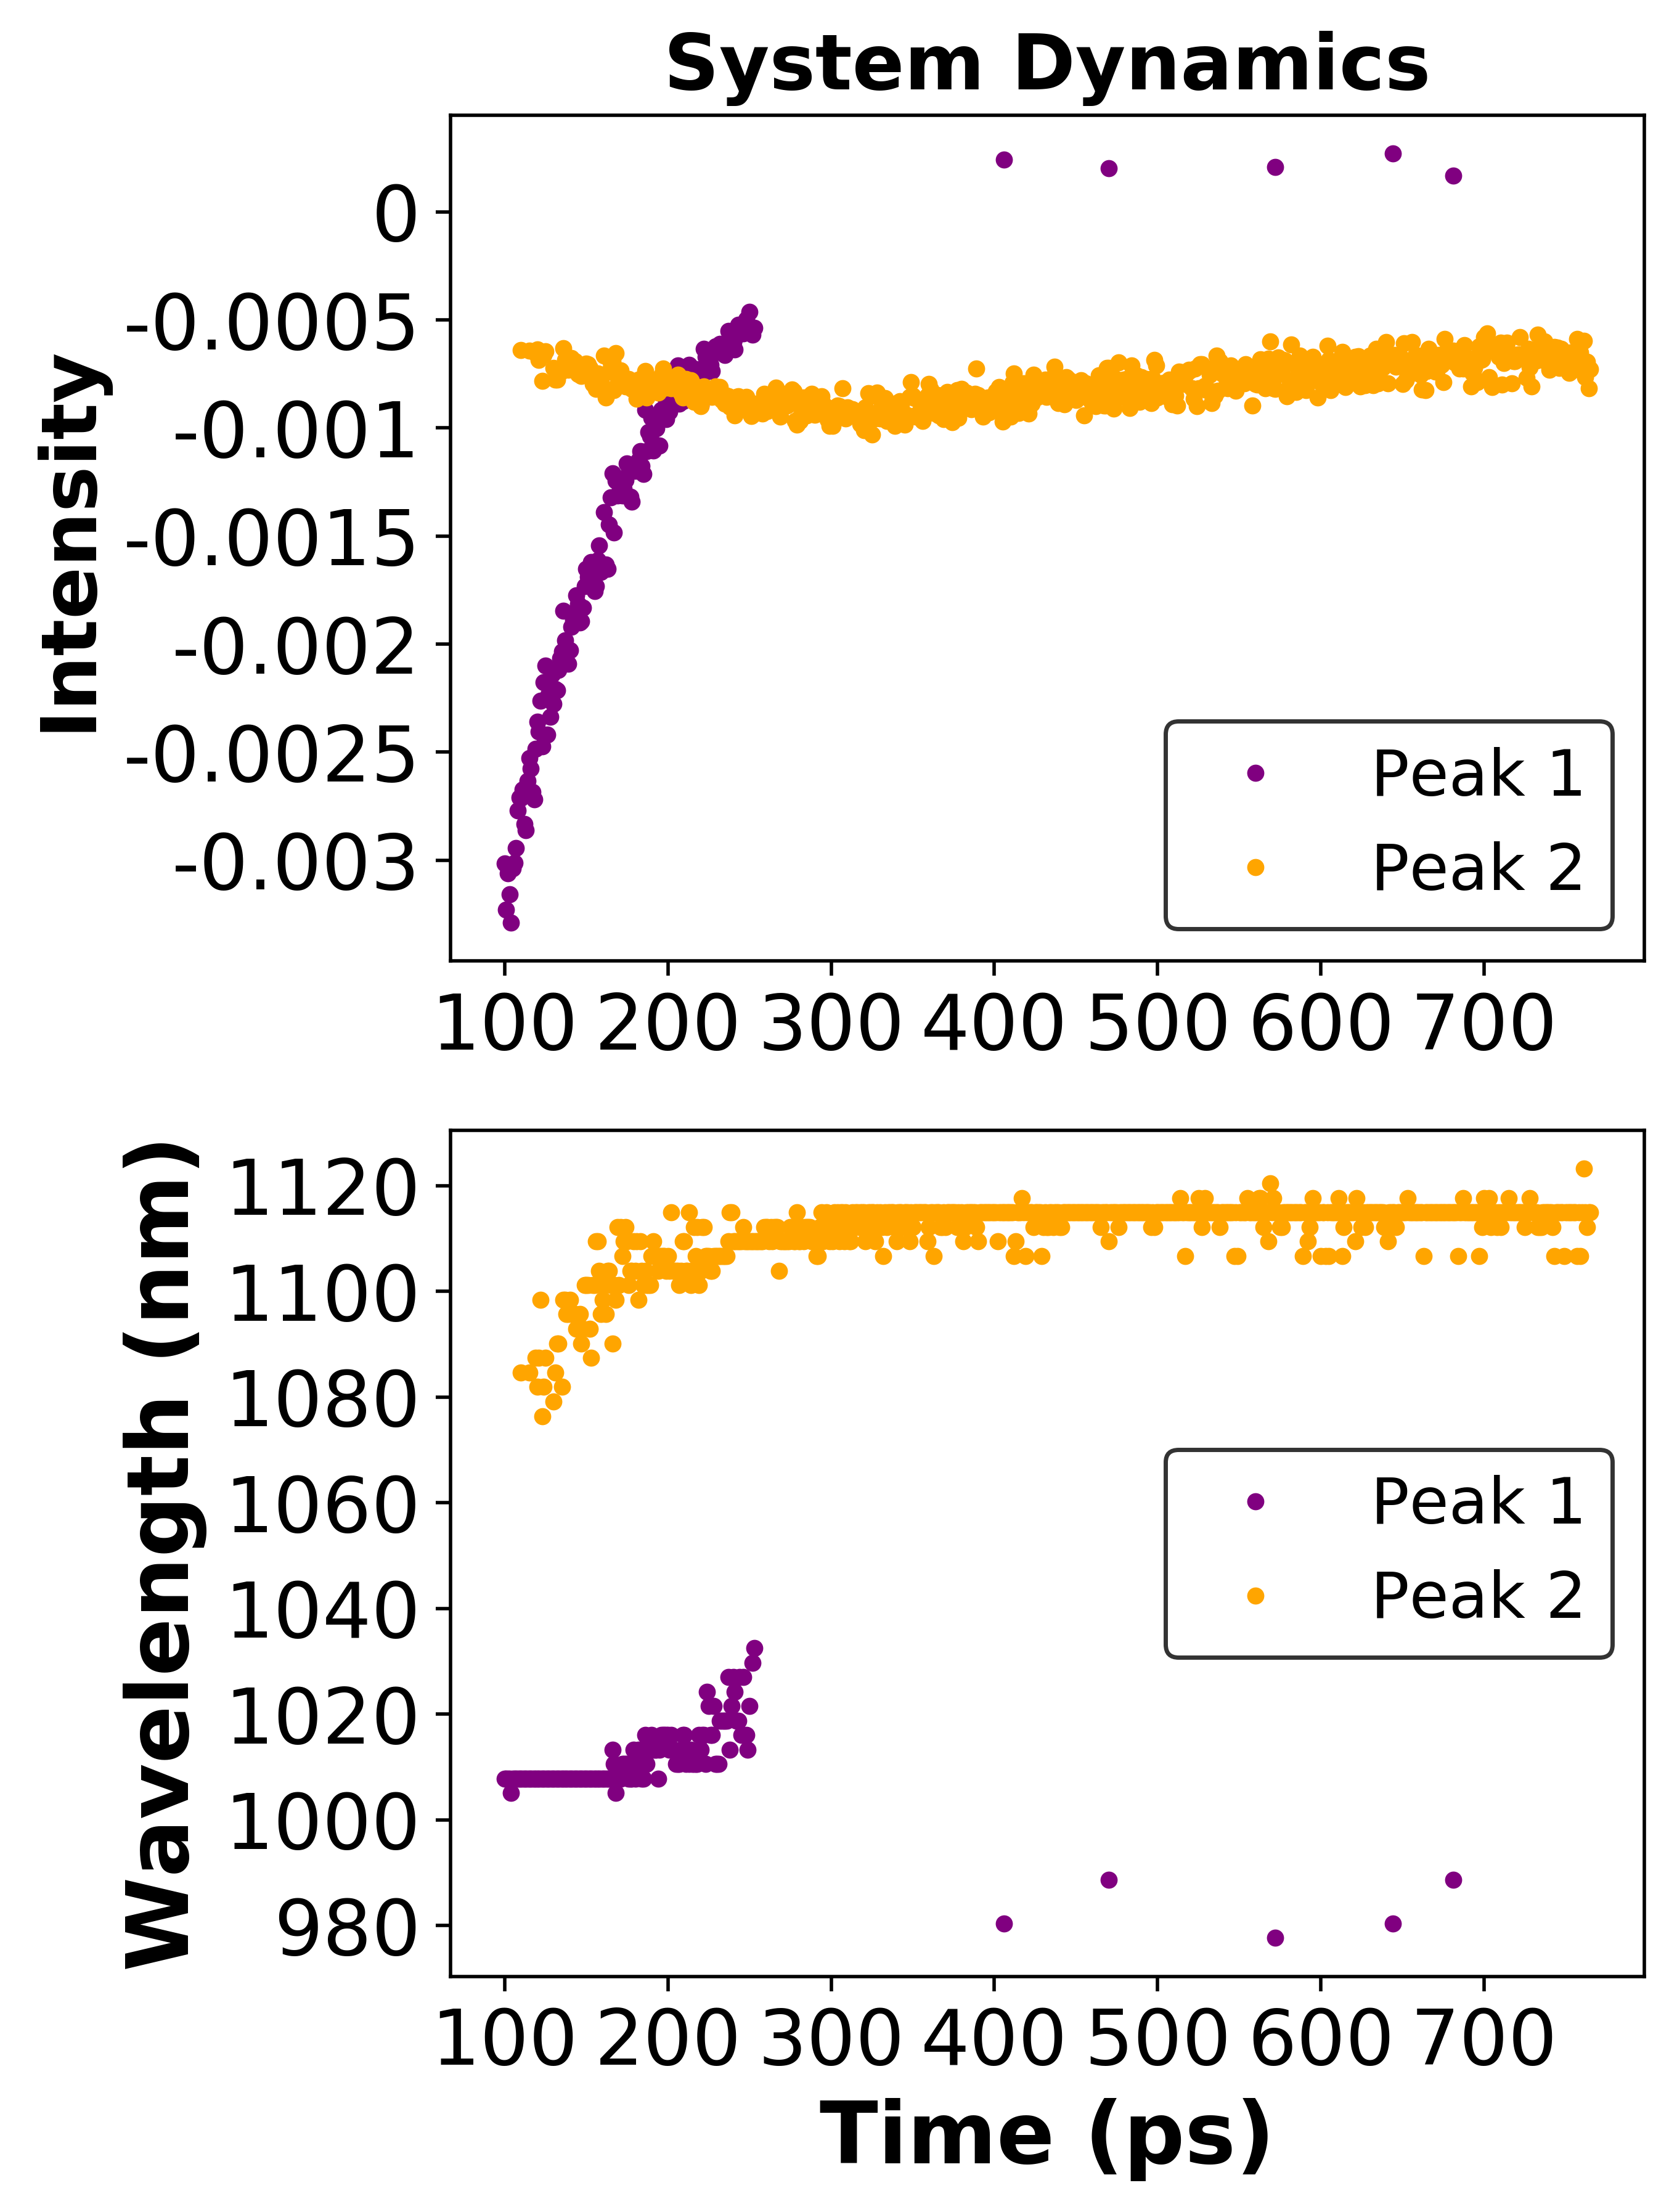

In [126]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5, 8), dpi=500)
fs = 20

ax1.plot(df1['Time'], df1['Height'], '.', label= 'Peak 1', color = 'purple')
ax1.plot(df2['Time'], df2['Height'], '.', label= 'Peak 2', color = 'orange')
ax1.set_title('System Dynamics', fontsize=18, fontweight='bold')
ax1.set_ylabel('Intensity', fontsize=18, fontweight='bold')
ax1_xticks = [0, 100, 200, 300, 400, 500, 600, 700]
ax1_yticks = [-0.0035, -0.003, -0.0025, -0.002, -0.0015, -0.001, -0.0005, 0, 0.0005]
ax1.set_xticklabels(ax1_xticks, fontsize = fs-2)
ax1.set_yticklabels(ax1_yticks, fontsize = fs-2)
ax1.legend(fontsize=15)
ax1.legend(fontsize=15, edgecolor = 'black')

   
ax2.plot(df1['Time'], df1['Wavelength'], '.', label= 'Peak 1', color = 'purple')
ax2.plot(df2['Time'], df2['Wavelength'], '.', label= 'Peak 2', color = 'orange')
ax2.set_ylabel('Wavelength (nm)', fontsize=fs, fontweight='bold')
ax2.set_xlabel('Time (ps)', fontsize=fs, fontweight='bold')
ax2_yticks = np.arange(960, 1140, 20)
ax2.set_xticklabels(ax1_xticks, fontsize = fs-2)
ax2.set_yticklabels(ax2_yticks, fontsize = fs-2)
ax2.legend(fontsize=15, edgecolor = 'black')

plt.show()

In [125]:
df1['Height']

0     -0.003516
1     -0.003728
2     -0.003561
3     -0.003659
4     -0.003789
5     -0.003537
6     -0.003514
7     -0.003445
8     -0.003270
9     -0.003209
10    -0.003214
11    -0.003174
12    -0.003333
13    -0.003363
14    -0.003133
15    -0.003027
16    -0.003076
17    -0.003184
18    -0.003220
19    -0.002984
20    -0.002860
21    -0.002906
22    -0.002764
23    -0.002974
24    -0.002677
25    -0.002601
26    -0.002920
27    -0.002733
28    -0.002835
29    -0.002639
         ...   
127   -0.001238
128   -0.001153
129   -0.001123
130   -0.001128
131   -0.001133
132   -0.001112
133   -0.001122
134   -0.001132
135   -0.001162
136   -0.001117
137   -0.001052
138   -0.001105
139   -0.001112
140   -0.001106
141   -0.001136
142   -0.001075
143   -0.001024
144   -0.001061
145   -0.001027
146   -0.001062
147   -0.000998
148   -0.001022
149   -0.000963
150   -0.001069
151   -0.001036
152   -0.000259
153   -0.000297
154   -0.000291
155   -0.000230
156   -0.000333
Name: Height, Length: 15

In [123]:
nm_range = 
abc = plot_decay(data_nm, data_time, 1400, data_z)

SyntaxError: invalid syntax (<ipython-input-123-6f6057a47bc1>, line 1)

In [175]:
data_time.shape

(173,)

In [159]:
def twodcontourplot(tadata_nm, tadata_timedelay, tadata_z_corr):
    """
    make contour plot
    
    Args:
        tadata_nm: wavelength array
        tadata_timedelay: time delay array
        tadata_z_corr: matrix of z values
        
    """
    nm, timedelay = np.linspace(tadata_nm.min(), tadata_nm.max(), 100), np.linspace(tadata_timedelay.min(), tadata_timedelay.max(), 100)    
    timedelayi, nmi = np.meshgrid(tadata_timedelay, tadata_nm)

    #find the maximum and minimum
    #these are used for color bar
    z_min = np.amin(np.amin(tadata_z_corr, axis = 1))
    z_max = np.amax(np.amax(tadata_z_corr, axis = 1))

    
    return [nmi, timedelayi, z_min, z_max]

TypeError: Dimensions of C (144, 707) are incompatible with X (173) and/or Y (144); see help(pcolormesh)

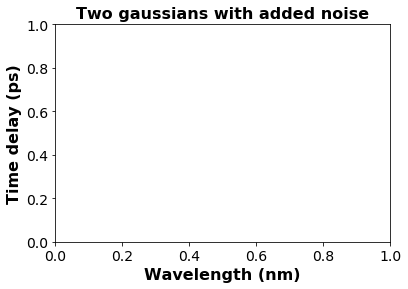

In [161]:
original_contour = twodcontourplot(data_nm, data_time, data_z)
nm_contour, time_contour, min_contour, max_contour = original_contour[0], original_contour[1], original_contour[2], original_contour[3]

plt.figure()
#plt.xlim(450,800)
plt.title('Two gaussians with added noise', fontsize = 16, fontweight = 'bold')
#plt.ylim(0,50)
plt.xlabel('Wavelength (nm)', fontsize = 16, fontweight = 'bold')
plt.ylabel('Time delay (ps)', fontsize = 16, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.pcolormesh(nm_contour, time_contour, data_z, cmap = 'PiYG', vmin=min_contour, vmax=max_contour)
plt.colorbar()
plt.tight_layout(pad=0.25, h_pad=None, w_pad=None, rect=None)